In [1]:
%matplotlib inline

# Classifying handwritten digits

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

c:\Users\Priel\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [3]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

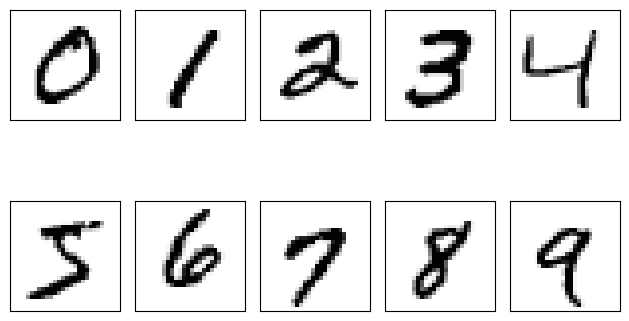

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Visualize 25 different versions of "7":

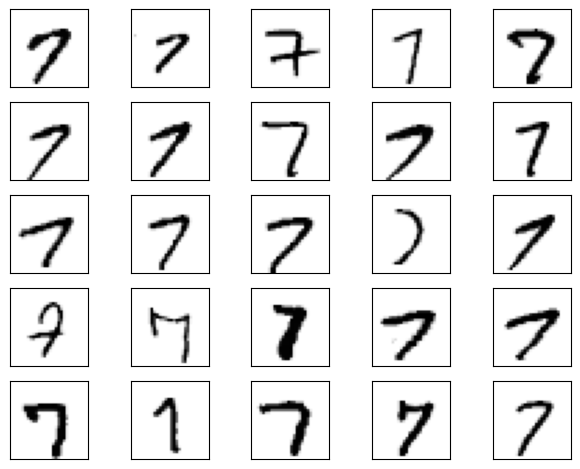

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

In [7]:
import numpy as np

In [8]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2,  num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden 1
        rng = np.random.RandomState(random_seed)
        
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        # hidden 2
        rng = np.random.RandomState(random_seed)
        
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer 1
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h2 = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        
        # [n_examples, n_hidden]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2
        
        # [n_examples, n_features]
        d_z_h2__d_w_h2 = a_h1
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h2 = np.dot(delta_h2.T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum(delta_h2, axis=0)


        # [n_classes, n_hidden]
        d_z_h2__a_h1 = self.weight_h2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
        
        # [n_examples, n_hidden]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h1__d_w_h1 = x 
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)


        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h2, d_loss__d_b_h2, 
                d_loss__d_w_h1, d_loss__d_b_h1)

In [9]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden1=50,
                     num_hidden2=50,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [10]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [11]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, _, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.2
Initial validation accuracy: 9.7%


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc


def compute_auc_score(nnet, X, y):
    _, _, probas = nnet.forward(X)

    y__bin = label_binarize(y, classes=np.unique(y))
    auc = roc_auc_score(y__bin, probas, average='macro')
    
    return auc

In [14]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.7%


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    train_loss = []
    valid_loss = []

    epoch_train_acc = []
    epoch_valid_acc = []

    epoch_train_auc = []
    epoch_valid_auc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1  = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        train_auc = compute_auc_score(model, X_train, y_train)
        valid_auc = compute_auc_score(model, X_valid, y_valid)
        train_auc, valid_auc = train_auc*100, valid_auc*100
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        train_loss.append(train_mse)
        valid_loss.append(valid_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Valid MSE: {valid_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Train AUC: {train_auc:.2f}%'
              f'| Valid AUC: {valid_auc:.2f}%')

    return train_loss, valid_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [16]:
np.random.seed(123) # for the training set shuffling

train_loss, valid_loss, epoch_train_acc, epoch_valid_acc,  epoch_train_auc, epoch_valid_auc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Valid MSE: 0.09 | Train Acc: 19.09% | Valid Acc: 19.14%| Train AUC: 78.45%| Valid AUC: 78.79%
Epoch: 002/050 | Train MSE: 0.09 | Valid MSE: 0.09 | Train Acc: 29.72% | Valid Acc: 29.79%| Train AUC: 85.16%| Valid AUC: 85.48%
Epoch: 003/050 | Train MSE: 0.08 | Valid MSE: 0.08 | Train Acc: 33.79% | Valid Acc: 34.01%| Train AUC: 88.05%| Valid AUC: 88.35%
Epoch: 004/050 | Train MSE: 0.07 | Valid MSE: 0.07 | Train Acc: 43.98% | Valid Acc: 44.39%| Train AUC: 88.51%| Valid AUC: 88.82%
Epoch: 005/050 | Train MSE: 0.06 | Valid MSE: 0.06 | Train Acc: 56.56% | Valid Acc: 57.06%| Train AUC: 90.41%| Valid AUC: 90.61%
Epoch: 006/050 | Train MSE: 0.05 | Valid MSE: 0.05 | Train Acc: 62.62% | Valid Acc: 62.98%| Train AUC: 91.66%| Valid AUC: 91.83%
Epoch: 007/050 | Train MSE: 0.05 | Valid MSE: 0.05 | Train Acc: 67.23% | Valid Acc: 67.37%| Train AUC: 92.67%| Valid AUC: 92.85%
Epoch: 008/050 | Train MSE: 0.04 | Valid MSE: 0.04 | Train Acc: 71.42% | Valid Acc: 71.35%| Train

## Evaluating the neural network performance

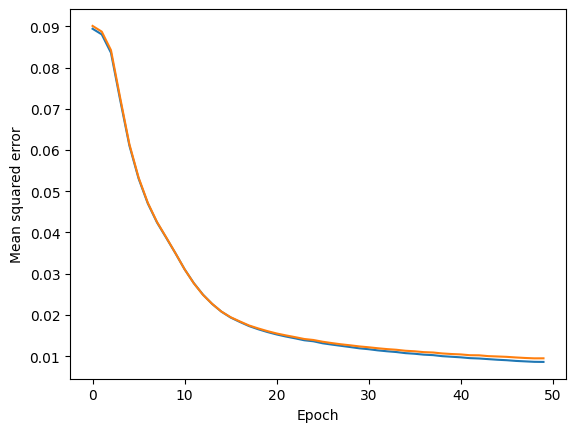

In [17]:
plt.plot(range(len(train_loss)), train_loss, label = "Training")
plt.plot(range(len(valid_loss)), valid_loss, label = "Validation")
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.savefig('2Lmse.png', dpi=300)
plt.show()

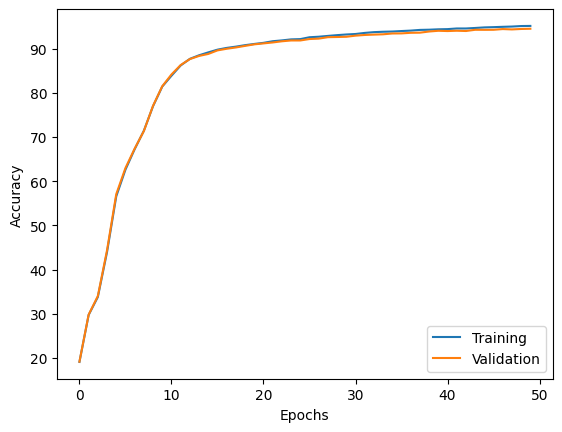

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

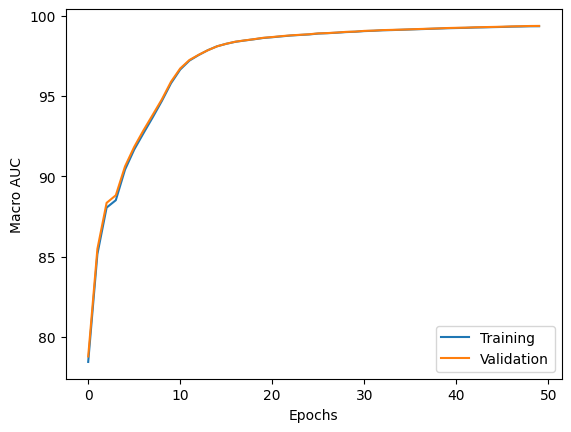

In [19]:
plt.plot(range(len(epoch_train_auc)), epoch_train_auc,
         label='Training')
plt.plot(range(len(epoch_valid_auc)), epoch_valid_auc,
         label='Validation')
plt.ylabel('Macro AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.savefig('2Lauc.png', dpi=300)
plt.show()

In [20]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 94.21%


In [21]:
test_auc = compute_auc_score(model, X_test, y_test)
print(f'Test Macro AUC: {test_auc*100:.2f}%')

Test Macro AUC: 99.25%


Plot failure cases:

In [22]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, _, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

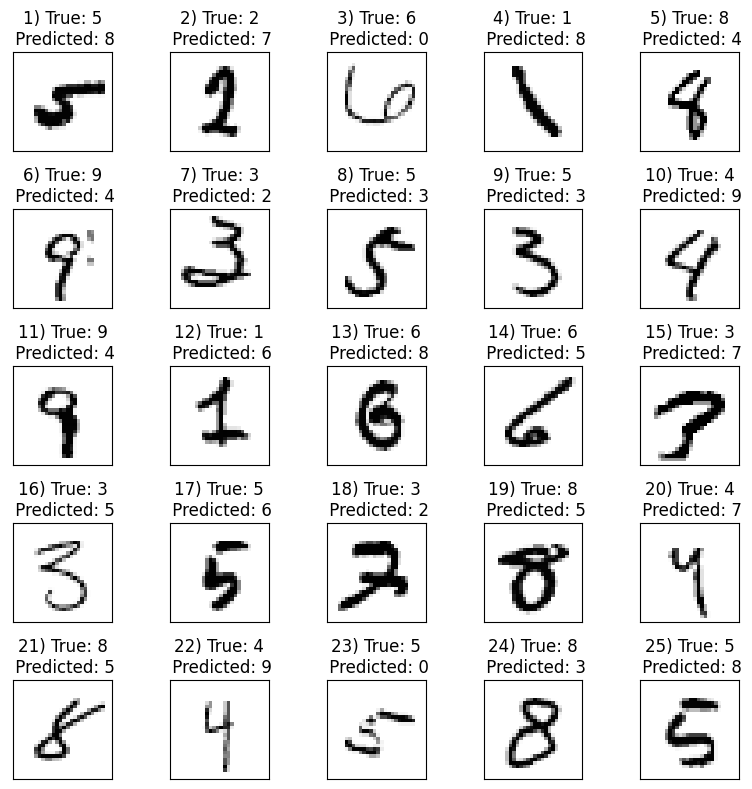

In [23]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.savefig('2Lwrong', dpi=300)
plt.show()

In [24]:
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def get_neural_net(num_features, num_hidden1, num_hidden2, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=(num_features,)))
    model.add(Dense(num_hidden1, activation='sigmoid'))
    model.add(Dense(num_hidden2, activation='sigmoid'))
    model.add(Dense(num_classes, activation='sigmoid'))

    return model

nnet = get_neural_net(num_features=28*28, num_hidden1=50, num_hidden2=50, num_classes=10)

y_train = label_binarize(y_train, classes=list(range(10)))
y_valid = label_binarize(y_valid, classes=list(range(10)))

nnet.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["AUC"])
history = nnet.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=100)

Epoch 1/50
392/392 [==============================] - 2s 2ms/step - loss: 1.1946 - auc: 0.9242 - val_loss: 0.5066 - val_auc: 0.9834
Epoch 2/50
392/392 [==============================] - 1s 2ms/step - loss: 0.3924 - auc: 0.9866 - val_loss: 0.3163 - val_auc: 0.9892
Epoch 3/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2854 - auc: 0.9906 - val_loss: 0.2553 - val_auc: 0.9915
Epoch 4/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2366 - auc: 0.9927 - val_loss: 0.2223 - val_auc: 0.9929
Epoch 5/50
392/392 [==============================] - 1s 2ms/step - loss: 0.2031 - auc: 0.9941 - val_loss: 0.2043 - val_auc: 0.9934
Epoch 6/50
392/392 [==============================] - 1s 2ms/step - loss: 0.1800 - auc: 0.9950 - val_loss: 0.1811 - val_auc: 0.9945
Epoch 7/50
392/392 [==============================] - 1s 2ms/step - loss: 0.1623 - auc: 0.9957 - val_loss: 0.1716 - val_auc: 0.9948
Epoch 8/50
392/392 [==============================] - 1s 2ms/step - loss: 0.

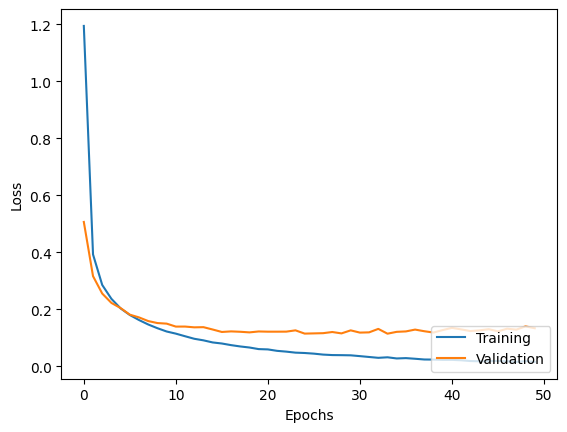

In [25]:
plt.plot(history.history["loss"], label='Training')
plt.plot(history.history["val_loss"], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.savefig('KERASloss.png', dpi=300)
plt.show()

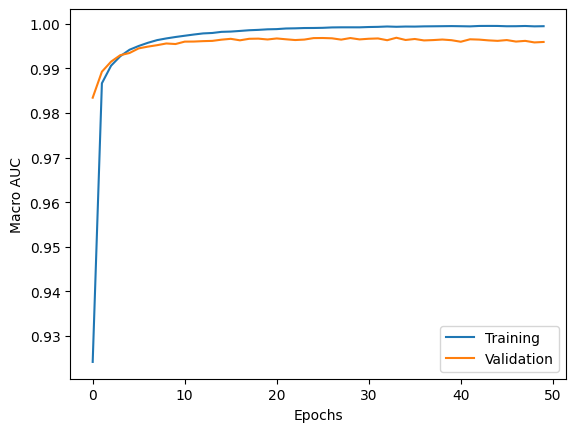

In [26]:
plt.plot(history.history["auc"], label='Training')
plt.plot(history.history["val_auc"], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Macro AUC')
plt.legend(loc='lower right')
plt.savefig('KERASauc.png', dpi=300)
plt.show()

In [27]:
probas = nnet.predict(X_test)
y_test_bin = label_binarize(y_test, classes=list(range(10)))
test_auc = roc_auc_score(y_test_bin, probas, average='macro')
print(f'Test Macro AUC: {test_auc*100:.2f}%')

657/657 [==============================] - 0s 656us/step
Test Macro AUC: 99.66%
